<a href="https://colab.research.google.com/github/SanghyukLEE99/Dream/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed
Epoch 1/100
9/9 [==============================] - 4s 92ms/step - loss: 0.2420 - val_loss: 0.2426
Epoch 2/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0613 - val_loss: 0.0022
Epoch 3/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0259 - val_loss: 0.0031
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0120 - val_loss: 0.0235
Epoch 5/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0127 - val_loss: 0.0064
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.0018
Epoch 7/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 8/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0020
Epoch 9/100
9/9 [==============================] - 

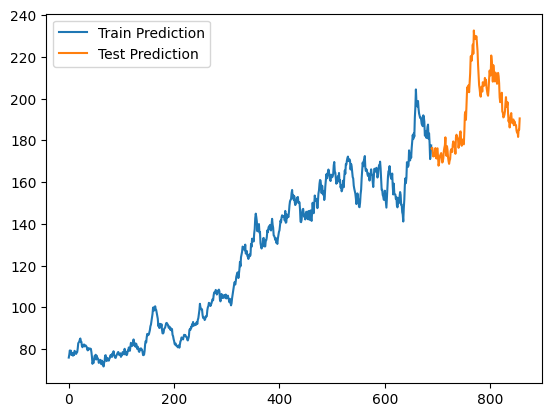

In [1]:
!pip install numpy pandas matplotlib pandas_datareader scikit-learn tensorflow yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
import yfinance as yf

# GBM Model
def GBM(stock, mu, std, dt, N, T, L):
    x0 = stock[0]
    t = np.linspace(0, T, L+1)
    exp = lambda t: math.exp(t)
    expfunc = np.vectorize(exp)
    dW = math.sqrt(dt)*np.random.normal(0, 1, L)  # Brownian Increment
    W = np.cumsum(dW)  # Make the Wiener process
    W = np.append([0], W)
    X = x0*expfunc((mu-((std**2)/2))*t + std*W)  # Calculate the solution curve to SDE to GBM with its closed form
    return X

# LSTM Model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def LSTM_Model(data, look_back=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data
    train_length = int(len(scaled_data) * 0.80)
    train_data = scaled_data[0:train_length, :]
    test_data = scaled_data[train_length:, :]

    # Create dataset
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)

    # Reshape data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    # LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Compile and fit model
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, validation_split=0.2, callbacks=[early_stopping])

    # Prediction
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    return train_predict, test_predict

# Download stock data
data = yf.download('AAPL', start='2020-01-01', end='2023-06-15')

# Use 'Close' column as stock prices
stock = data['Close'].values.reshape(-1, 1)

# Example
mu = 2
std = 1
dt = 0.001
N = 100
T = 1
L = 1000

# Predict with GBM
gbm_prediction = GBM(stock[:, 0], mu, std, dt, N, T, L)

# Predict with LSTM
lstm_prediction_train, lstm_prediction_test = LSTM_Model(stock, look_back=5)

# Average the predictions
average_prediction_train = (gbm_prediction[:len(lstm_prediction_train)] + lstm_prediction_train.flatten()) / 2
average_prediction_test = (gbm_prediction[len(lstm_prediction_train):len(lstm_prediction_train) + len(lstm_prediction_test)] + lstm_prediction_test.flatten()) / 2

# Plot the results
plt.plot(average_prediction_train, label='Train Prediction')
plt.plot(range(len(average_prediction_train), len(average_prediction_train) + len(average_prediction_test)), average_prediction_test, label='Test Prediction')
plt.legend()
plt.show()
